In [6]:
#import all packages needed
import numpy as np
import pandas as pd
import math
from scipy.stats import norm, skewnorm, cauchy, lognorm
import logging
import json
import sys
import os

import xlwt
import xlsxwriter
from tempfile import TemporaryFile

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

pydice_folder = os.path.dirname(os.getcwd()) + '\\1_Model'
sys.path.append(pydice_folder)

from PyRICE_V9 import PyRICE

In [7]:
#Import data of original RICE2010 for plotting
RICE_DATA = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Data")
RICE_PARAMETER = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Parameters")
RICE_DAMAGE = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Damage")
RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")
RICE_results = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Results")

regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
                "Latin America","OHI","Other non-OECD Asia"]

In [8]:
#get dataframe format to support plotting of results
RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")

regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
    "Latin America","OHI","Other non-OECD Asia"]

"""
####################### Population PARAMETERS and set up dataframe format #######################
"""
#get population growth rates for each region
a=[]
for i in range(31):  
    if i == 0:
        a.append("region")
    k = 2005 + 10 * i
    k = str(k)
    a.append(k)    

region_pop_gr = RICE_POP_gr.iloc[10:22,3:35]
region_pop_gr.columns =  a
region_pop_gr = region_pop_gr.set_index('region') 

In [9]:
#Run PyRICE with all controls from original RICE2010
model = PyRICE(steps = 31, model_specification="Validation_1",fdamage=1, welfare_function="utilitarian")
results = model()

In [10]:
#Get results from RICE2010 optimal run
validation_series = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Validation series")

sr_opt_series = validation_series.iloc[21:33,3:34]
sr_opt_series.index = region_pop_gr.index
sr_opt_series.columns = region_pop_gr.columns

miu_opt_series = validation_series.iloc[6:18,3:34]
miu_opt_series.index = region_pop_gr.index
miu_opt_series.columns = region_pop_gr.columns

utility = validation_series.iloc[48:49,3:34]
utility.columns = region_pop_gr.columns

damages = validation_series.iloc[51:52,3:34]
damages.columns = region_pop_gr.columns

temperature = validation_series.iloc[54:55,3:34]
temperature.columns = region_pop_gr.columns

emissions = validation_series.iloc[57:58,3:34]
emissions.columns = region_pop_gr.columns

total_output = validation_series.iloc[60:61,3:34]
total_output.columns = region_pop_gr.columns



'\nNote, damage fraction fit from Denig (NICE model) only corresponds to correct damage fractions generated in RICE from 2005 - 2135. \nAfter that damage fractions start to deviate because SLR is still there but temperature goes down. \nMaybe nice to build in SLR and use it for uncertainty analysis.\n\n'

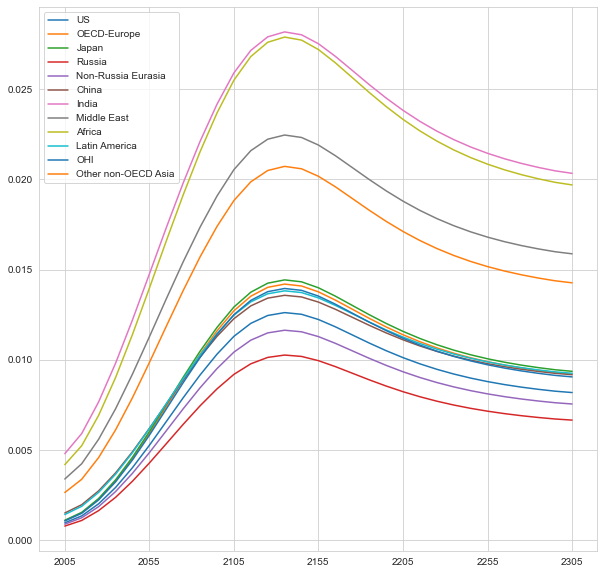

In [11]:
#Plot damages frac behaviour with fitted parameters based from Denig 2015
sns.set_style("whitegrid")
output_frac = model.dam_frac.transpose()
output_frac = pd.DataFrame(data=output_frac,index = region_pop_gr.columns,columns = region_pop_gr.index)
output_frac.plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')

'''
Note, damage fraction fit from Denig (NICE model) only corresponds to correct damage fractions generated in RICE from 2005 - 2135. 
After that damage fractions start to deviate because SLR is still there but temperature goes down. 
Maybe nice to build in SLR and use it for uncertainty analysis.

'''

'\ndifference thus based on SLR damages which only cover fit for the optimisation period. \nSLR damage after 2105 is still considerable. Therefore, SLR damage fucnction could be maybe build in.\n'

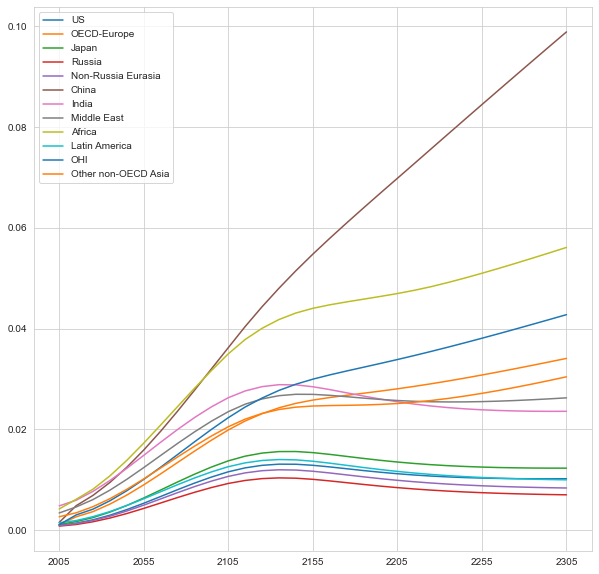

In [12]:
#Damages frac behaviour of the original RICE model damage function
damages_frac = validation_series.iloc[65:77,3:34]
damages_frac.columns = region_pop_gr.columns
damages_frac.index = region_pop_gr.index

sns.set_style("whitegrid")

damages_frac.transpose().plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')
#output_frac.plot(subplots=True,secondary_y=False, style='g')

'''
difference thus based on SLR damages which only cover fit for the optimisation period. 
SLR damage after 2105 is still considerable. Therefore, SLR damage fucnction could be maybe build in.
'''

In [13]:
#output PyRICE
output_Y = model.Y
output_E = model.E
output_U = model.per_util_ww
output_D = model.damages
output_T = model.temp_atm

output_Y = pd.DataFrame(data=output_Y,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_Y = output_Y.transpose()
output_Y.loc[:,'Global PyRICE'] = output_Y.sum(axis=1)

output_E = pd.DataFrame(data=output_E,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_E = output_E.transpose()
output_E.loc[:,'Global PyRICE'] = output_E.sum(axis=1)

output_U = pd.DataFrame(data=output_U,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_U = output_U.transpose()
output_U.loc[:,'Global PyRICE'] = output_U.sum(axis=1)

output_D = pd.DataFrame(data=output_D,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_D = output_D.transpose()
output_D.loc[:,'Global PyRICE'] = output_D.sum(axis=1)

output_T = pd.DataFrame(data=output_T)
output_T.columns = ["Global PyRICE"]
output_T.index = output_D.index

output_U['Global RICE'] = utility.transpose()
output_Y['Global RICE'] = total_output.transpose()
output_E['Global RICE'] = emissions.transpose()
output_D['Global RICE'] = damages.transpose()
output_T['Global RICE'] = temperature.transpose()

output_T = output_T[['Global RICE','Global PyRICE']]
output_Y = output_Y[['Global RICE','Global PyRICE']]
output_E = output_E[['Global RICE','Global PyRICE']]
output_D = output_D[['Global RICE','Global PyRICE']]
output_U = output_U[['Global RICE','Global PyRICE']]

output_PyRICE = [output_Y,output_E,output_U,output_D,output_T]
plot_df = pd.concat(output_PyRICE, axis=1)

In [14]:
output_PyRICE = [output_Y,output_E,output_U,output_D,output_T]
plot_df = pd.concat(output_PyRICE, axis=1)

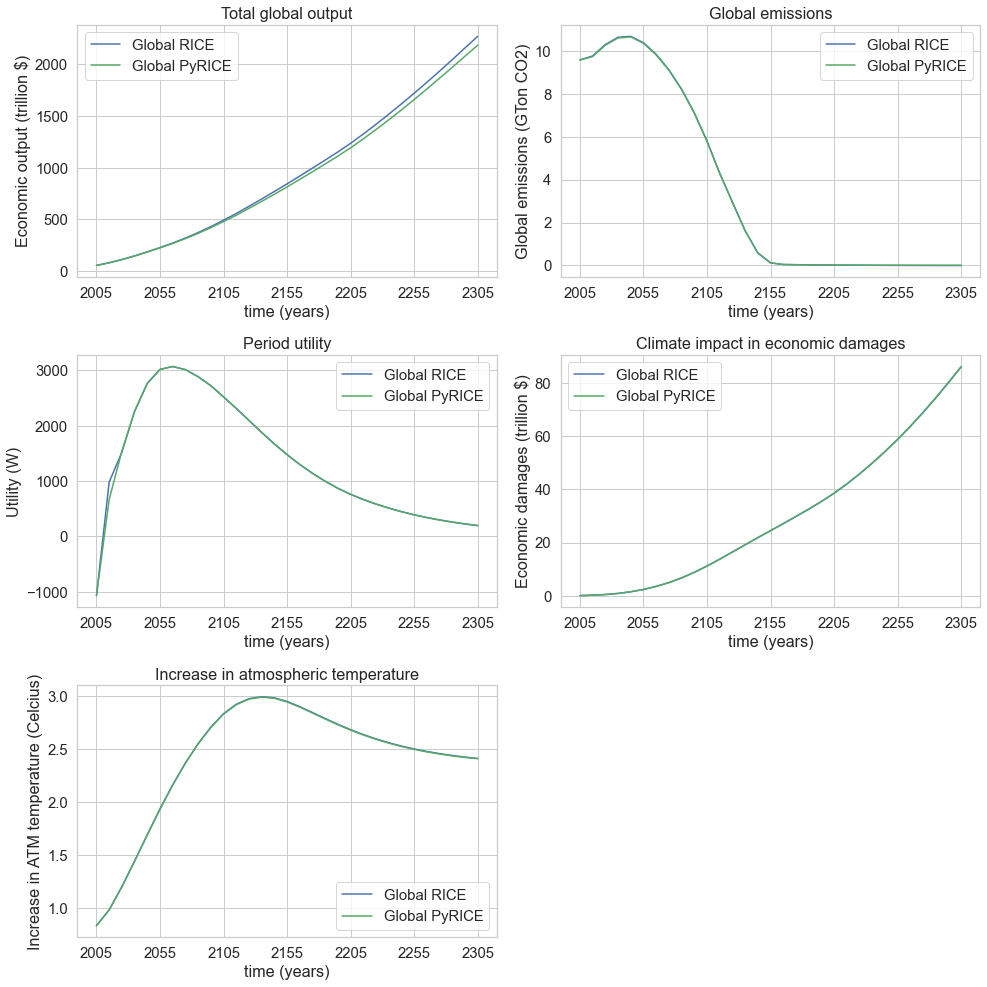

In [15]:
#set up graph with subplots to compare with original RICE output
sns.set(font_scale=1.35)  # crazy big
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14),tight_layout=True)
fig.delaxes(axes[2][1])

#fig.suptitle("Comparison of model outputs using original input for levers", fontsize=14)
plot_df.iloc[:,0].plot(ax=axes[0,0]); axes[0,0].set_title('Total global output'),axes[0,0].legend()
axes[0,0].set(xlabel='time (years)', ylabel='Economic output (trillion $)')
plot_df.iloc[:,1].plot(ax=axes[0,0],secondary_y=False, style='g'); axes[0,0].legend()


plot_df.iloc[:,2].plot(ax=axes[0,1]); axes[0,1].set_title('Global emissions'),axes[0,1].legend()
axes[0,1].set(xlabel='time (years)', ylabel='Global emissions (GTon CO2)')
plot_df.iloc[:,3].plot(ax=axes[0,1],secondary_y=False, style='g');axes[0,1].legend()


plot_df.iloc[:,4].plot(ax=axes[1,0]); axes[1,0].set_title('Period utility'),axes[1,0].legend()
axes[1,0].set(xlabel='time (years)', ylabel='Utility (W)')
plot_df.iloc[:,5].plot(ax=axes[1,0],secondary_y=False, style='g');axes[1,0].legend()


plot_df.iloc[:,6].plot(ax=axes[1,1]); axes[1,1].set_title('Climate impact in economic damages'), axes[1,1].legend()
axes[1,1].set(xlabel='time (years)', ylabel='Economic damages (trillion $)')
plot_df.iloc[:,7].plot(ax=axes[1,1],secondary_y=False, style='g'); axes[1,1].legend()

plot_df.iloc[:,8].plot(ax=axes[2,0]); axes[2,0].set_title('Increase in atmospheric temperature'), axes[2,0].legend()
axes[2,0].set(xlabel='time (years)', ylabel='Increase in ATM temperature (Celcius)')
plot_df.iloc[:,9].plot(ax=axes[2,0],secondary_y=False, style='g'); axes[2,0].legend()

plt.legend()

plt.savefig("validation_output_fixed_control.png", dpi=200)

In [16]:
output_sr = model.S[:,0:31]
output_sr = pd.DataFrame(data=output_sr,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_sr = output_sr.transpose()

output_miu = model.miu[:,0:31]
output_miu = pd.DataFrame(data=output_miu,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_miu = output_miu.transpose()

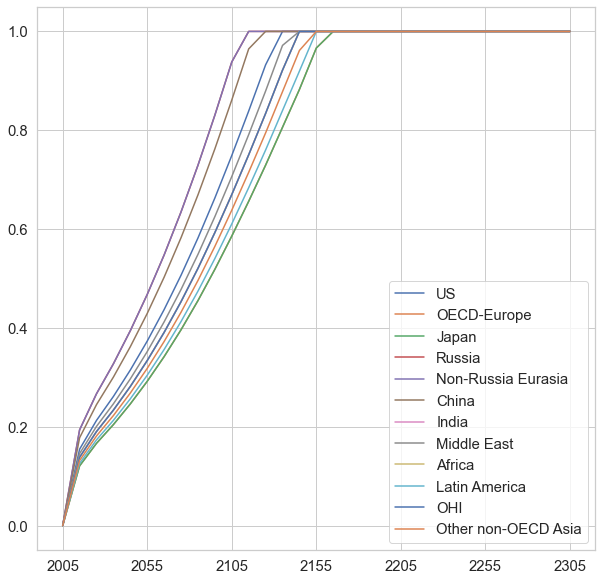

In [17]:
sns.set_style("whitegrid")

output_miu.plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')

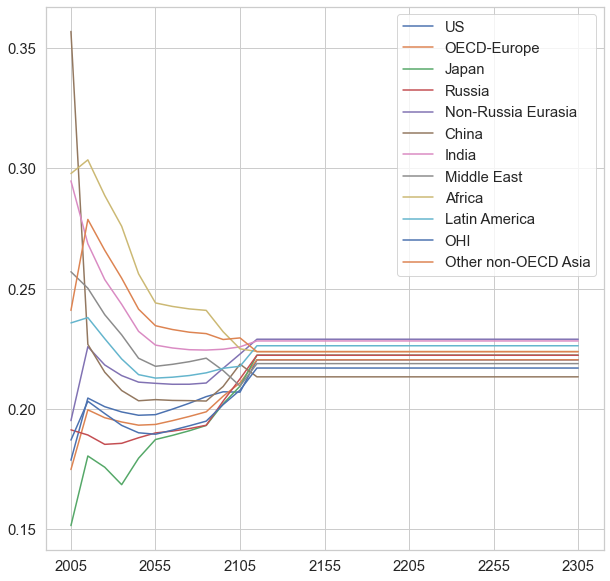

In [18]:
sns.set_style("whitegrid")

output_sr.plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')

In [19]:
pop_output = model.region_pop[:,0:31]
pop_output = pd.DataFrame(data=pop_output,index =region_pop_gr.index ,columns = region_pop_gr.columns)
pop_output = pop_output.transpose()

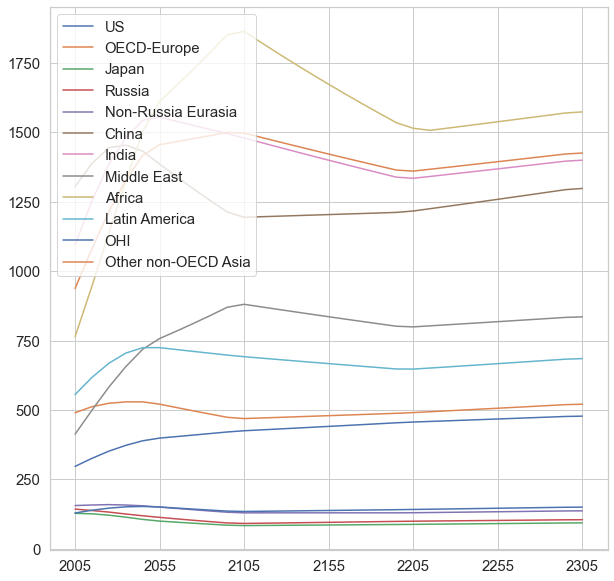

In [20]:
sns.set_style("whitegrid")

pop_output.plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')

In [21]:
pop_output["global"] = pop_output.sum(axis=1)